# **Project: Multitask Learning for Geometric Shape Classification and Counting**

## 1. Overview

In this project, you will design, implement, and evaluate a **multitask neural network** that performs **two tasks simultaneously**:

1. **Classification** – identify which pair of geometric shape types appears in a 28×28 binary image (135 possible configurations).
2. **Regression** – predict how many shapes of each type are present (6 regression targets).

This project focuses on **multi-task learning**, i.e., using one shared model to learn several related tasks at once. You will compare how adding an auxiliary task affects performance and training dynamics.

---

## 2. Dataset

You will use the **Geometric Shape Numbers (GSN)** dataset:

```bash
!wget https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip
```

This will create a directory `data/` containing:

* **10,000 images** (28×28x1, grayscale)
* **labels.csv** – counts of each of six shape types per image

Each image contains exactly **two types** of geometric figures (out of six) and **10 shapes total**.

**Shape classes:**

| Index | Shape type     |
| ----: | -------------- |
|     0 | square         |
|     1 | circle         |
|     2 | triangle up    |
|     3 | triangle right |
|     4 | triangle down  |
|     5 | triangle left  |

Example row from `labels.csv`:

```
name,squares,circles,up,right,down,left
img_00000.png,0,0,0,4,0,6
```

Here, the image contains **4 right-pointing triangles** and **6 left-pointing triangles**.

**Split:**

* Training: first 9,000 samples
* Validation: last 1,000 samples

Examples:
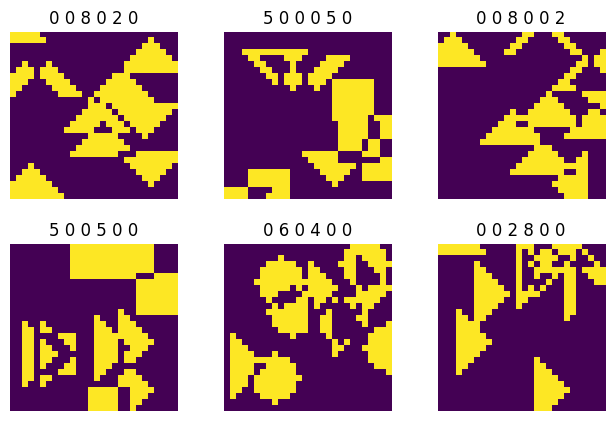

---

## 3. Tasks and objectives

You must design a **multitask deep learning system** that:

1. **Classifies** each image into one of **135 possible configurations**, representing:

   * which **two shape classes** appear, and
   * how their counts (1–9) sum to 10.

   → Example: "3 circles + 7 squares" is one configuration class.

2. **Regresses** the number of shapes of each type (a 6-dimensional real-valued output).

3. Combines both objectives in a **joint loss** function (Hint: losses are implemented in PyTorch):


$$ Loss = \text{NLLLoss(classification)} + \lambda_{\text{cnt}} \cdot \text{SmoothL1Loss(regression)}
$$

---

## 4. Model requirements

### Architecture constraints

You must use **exactly this feature extractor (backbone)**:

```python
nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(64 * 28 * 28, 256), nn.ReLU()
)
```

Then add **two separate heads**:

* `head_cls`: outputs log-probabilities for 135 classes
* `head_cnt`: outputs 6 regression values (counts)

The model must return two outputs: `(log_probs, counts)`.

You may add dropout or batch normalization inside the heads, **but you must not modify the backbone**.

---

## 5. Training setup

* Optimizer: **Adam**, learning rate = 1e-3
* Epochs: up to **100** (use **early stopping**)
* Batch sizes: **64** (train), **1000** (validation)
* Device: GPU allowed for Notebook, but your **final code must run on GPU within ~30 minutes**
* Random seed: set `torch.manual_seed(1)` for reproducibility
* Split: **exactly 9,000 train / 1,000 validation**


---

## 6. Data preprocessing and augmentation

You must implement a **PyTorch `Dataset` class** that:

* Reads `labels.csv`
* Loads the corresponding image (from `data/`)
* Returns both:
  * the image (as a tensor)
  * the labels (counts for 6 shapes)
* Optionally applies transformations

### Required augmentations

You must implement **at least three** of the following:

1. Random horizontal flip
2. Random vertical flip
3. Random 90° rotation (must correctly rotate orientation labels: up → right → down → left)
4. Random brightness/contrast (mild)
5. Gaussian noise
6. Random erasing (small areas only)


---

## 7. Evaluation metrics

Implement and report the following metrics on the validation set:

### (a) **Classification (135-way)**

* Top-1 accuracy
* Macro F1-score
* Per-pair accuracy (aggregate by unordered shape pair, e.g. {circle, up})

### (b) **Regression (6-D counts)**

* RMSE per class and overall
* MAE per class and overall

Also plot:

* Training and validation losses
* Validation accuracy and RMSE over epochs

**Important**: This task is not about finding the best architecture; we expect at least 50% accuracy, but achieving results higher than that will not affect the grade for the assignment**.


---

## 8. Experiments and analysis

You must train and compare **three model settings**:

| Setting | Description                                      |
| :------ | :----------------------------------------------- |
| 1       | **Classification-only:** λ_cnt = 0               |
| 2       | **Regression-only:** classification loss ignored |
| 3       | **Multitask:** λ_cnt = with your choose          |

For each experiment:

* Train until early stopping
* Record loss, accuracy, RMSE, and runtime
* Compare results and explain how λ influences learning
* Discuss whether multitask learning improves the main tasks


---

## 9. Final deliverables

You must submit .zip project with:

1. **Code** (`.ipynb` or `.py`) that:

   * Downloads and extracts the dataset
   * Defines dataset, dataloaders, model, loss, training loop, evaluation, and plotting
   * Can run start-to-end without interaction, and finishes within 30 minutes on Colab T4 GPUs
   * Includes three experiment configurations

2. **Report (2–4 pages, PDF)** including:
   * Section on (EDA) Exploratory Data Analysis in your report: no more than 3 graphs or tables describing the data set.
   * Model architecture
   * Description and justification of augmentations
   * Results table (loss, accuracy, RMSE for all runs)
   * Learning curves
   * Discussion on multitask effects

3. **README.md**:

   * Link to Colab version of task for fast replication.
   * Approximate runtime and resource requirements

---

## 10. Grading rubric

Component	Description	Points
1. Implementation correctness	Correct use of the fixed backbone, two-headed model, and proper training loop (classification + regression).	30%
2. Data & augmentations	Proper dataset loading, preprocessing, and at least three augmentations with brief justification.	20%
3. Evaluation & experiments	Correct computation of metrics (accuracy, F1, RMSE) and completion of all three λ configurations (λ=0, regression-only, your choice λ).	30%
4. Report & analysis
A clear separation of concerns (e.g. headers in notebooks, modules in code) and concise 2–4 page report with results tables, learning curves, confusion matrix, and short discussion on multitask effects and error examples.
20%

###### Readability and modularity will be considered within each grading component. Clear structure (headers in notebooks, docstrings, modular code) significantly improves evaluation speed. Emphasize using clear headers to help reviewers navigate efficiently.
---

In [3]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

from pathlib import Path
from PIL import Image
import torch
import torch.nn
from torch import Tensor
from typing import cast
from torchvision.transforms import v2
import numpy as np
import torchvision.transforms as T
import PIL
import pandas as pd
from torchvision import transforms




--2025-11-24 21:14:48--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-24 21:14:49--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.05s   

2025-11-24 21:14:49 (116 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1)

directory_in_str = "data"
class RandomHorizontalFlip(torch.nn.Module): # here define it for both the img and the label, which itsel is just a list
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img, label: np.ndarray):
        imgNew = img.copy()
        labelNew = label.copy()
        if torch.rand(1) < self.p:
            imgNew =  T.functional.hflip(imgNew)
            placeHold = labelNew[5]
            labelNew[5] = labelNew[3]
            labelNew[3] = placeHold

        return imgNew, labelNew


class RandomVerticalFlip(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img, label: np.ndarray):
        imgNew = img.copy()
        labelNew = label.copy()
        if torch.rand(1) < self.p:

            imgNew =  T.functional.hflip(imgNew)
            placeHold = labelNew[2]
            labelNew[2] = labelNew[4]
            labelNew[4] = placeHold

        return imgNew, labelNew

class Random90DegFlip(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img, label: np.ndarray):
        imgNew = img.copy()
        labelNew = label.copy()
        if torch.rand(1) < self.p:
            imgNew =  T.functional.rotate(imgNew,90)
            plcHoldUp = labelNew[2]
            plcHolLeft = labelNew[5]
            plcHolDown = labelNew[4]
            plcHolRight = labelNew[3]

            labelNew[2] = plcHolLeft # 2 becomes 5
            labelNew[3] = plcHoldUp # 3 becomes 2
            labelNew[4] = plcHolRight # 4 becomes 3
            labelNew[5] = plcHolDown # 5 becomes 4
        return imgNew, labelNew


indexDict = {
    "01":0,
    "02":1,
    "03":2,
    "04":3,
    "05":4,
    "12":5,
    "13":6,
    "14":7,
    "15":8,
    "23":9,
    "24":10,
    "25":11,
    "34":12,
    "35":13,
    "45":14
}

valDict = {
    "19":0,
    "28":1,
    "37":2,
    "46":3,
    "55":4,
    "64":5,
    "73":6,
    "82":7,
    "91":8,
}

def listToNum(y):
  # here y is [0,0,3,7,0,0]
  val1,val2,i1,i2 = -1,-1,-1,-1
  for i in range(6):
    if y[i] != 0:
      if val1 == -1:
        val1 = y[i]
        i1 = i
      else:
        val2 = y[i]
        i2 = i
  ixPair = str(int(i1)) + str(int(i2))
  ixVal = indexDict[ixPair]

  valPair = str(int(val1)) + str(int(val2))
  valVal = valDict[valPair]
  finalIx = ixVal * 9 + valVal
  #print("Y: ",y)
  #print("ixPair and valPair: ",ixVal,valVal)
  #print("final index: ", finalIx)

  return finalIx



class MyDataset(torch.utils.data.Dataset):
  def __init__(self,X,Y):
    self.X = X
    self.Y = Y
    self.Random90DegFlip = Random90DegFlip()
    self.RandomVerticalFlip = RandomVerticalFlip()
    self.RandomHorizontalFlip = RandomHorizontalFlip()
  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    X,Yr = self.X[idx], self.Y[idx]


    X,Yr = self.Random90DegFlip(X,Yr)
    X,Yr = self.RandomVerticalFlip(X,Yr)
    X,Yr = self.RandomHorizontalFlip(X,Yr)
    X = T.functional.to_tensor(X)
    Yc = listToNum(Yr)
    Yr,Yc = torch.tensor(Yr), torch.tensor(Yc)
    return X,Yc,Yr


def tensorToPil(image: Tensor) -> PIL.Image.Image:
  img = T.functional.to_pil_image(image)
  return img


class MyDatasetClassification(torch.utils.data.Dataset):
  def __init__(self,X,Y):
    self.X = X
    self.Y = Y
    self.Random90DegFlip = Random90DegFlip()
    self.RandomVerticalFlip = RandomVerticalFlip()
    self.RandomHorizontalFlip = RandomHorizontalFlip()

  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    X,Y = self.X[idx], self.Y[idx]
    '''
    X,Y = self.Random90DegFlip(X,Y)
    X,Y = self.RandomVerticalFlip(X,Y)
    X,Y = self.RandomHorizontalFlip(X,Y)
    '''
    X = T.functional.to_tensor(X)
    Y = listToNum(Y)
    X,Y = torch.tensor(X), torch.tensor(Y)
    return X,Y


def tensorToPil(image: Tensor) -> PIL.Image.Image:
  img = T.functional.to_pil_image(image)
  return img




class ModelCombined(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.bb = torch.nn.Sequential(
    torch.nn.Conv2d(1, 8, 3, stride=1, padding=1), torch.nn.ReLU(),
    torch.nn.Conv2d(8, 16, 3, stride=1, padding=1), torch.nn.ReLU(),
    torch.nn.Conv2d(16, 32, 3, stride=1, padding=1), torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, 3, stride=1, padding=1), torch.nn.ReLU(),
    torch.nn.Flatten(start_dim=1),
    torch.nn.Linear(64 * 28 * 28, 256), torch.nn.ReLU()
)
    self.classPart = torch.nn.Sequential(
        torch.nn.BatchNorm1d(256),
        torch.nn.Linear(256,256),
        torch.nn.Sigmoid(),
        torch.nn.Linear(256,135),
        torch.nn.LogSoftmax(dim=1)
    )
    self.regPart = torch.nn.Sequential(
        torch.nn.BatchNorm1d(256),
        torch.nn.Linear(256,6),
        torch.nn.ReLU()
    )


  def forward(self,x):
    x = self.bb(x)
    return self.classPart(x), self.regPart(x) # use the same head backbone, output two different things


def train(model, device, trainLoader,opt, epoch,logInterv):
  model.train()
  for batch_idx, (data, targetC,targetR) in enumerate(trainLoader):
    data, targetC,targetR = data.to(device), targetC.to(device),targetR.to(device)
    opt.zero_grad()
    outputC, outputR = model(data)
    #print("dziala 1")
    #print("OUTPUT 2 and TARGET 2: ", outputC.shape, targetC.shape, outputR.shape,targetR.shape)
    lossC = torch.nn.functional.nll_loss(outputC,targetC)
    #print("dziala 2 ")
    lossR = torch.nn.functional.smooth_l1_loss(outputR,targetR)


    loss = 0.7 * lossC   +  0.3 * lossR # let's try linear loss at first
    loss.backward()


    opt.step()


    if batch_idx % logInterv == 0:
      done, total = batch_idx * len(data) , len(trainLoader.dataset)
      print(
          f"Train Epoch: {epoch}, [{done}/{total} images ({done / total:.0%})] \t"
          + f"loss {loss.item():.6f}" + f" Partial Loss: {lossC.item():.6f}" + f" LossR: {lossR.item():.6f}"
      )


def test(model, device, trainLoader, epoch, logInterv):
  model.eval()
  testLoss = 0
  total = 0
  correctR = 0

  correctC = 0
  with torch.no_grad():
    for data, targetC, targetR in trainLoader:
      data, targetC, targetR = data.to(device), targetC.to(device), targetR.to(device)
      outputC,outputR = model(data)
      #print("OUTPUT: ", outputR," TARGET: ", targetR)
      loss = 0.5 * torch.nn.functional.nll_loss(outputC,targetC) + 0.5 * torch.nn.functional.smooth_l1_loss(outputR,targetR)
      testLoss += loss

      outputC = outputC.argmax(dim=1) # this outputs C numbers, so our predictions
      #print("Target C: ", targetC, " output c: ", outputC)

      correctR += (outputR == targetR).sum().item()
      total += trainLoader.batch_size

      correctC += (outputC == targetC).sum().item()

    testLoss /= total

    print(f"Test loss: {testLoss}, For classification: {correctC} / {total}, Regression: {correctR} / {total}" )



class ModelClass(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.bb = torch.nn.Sequential(
      torch.nn.Conv2d(1, 8, 3, stride=1, padding=1), torch.nn.ReLU(),
      torch.nn.Conv2d(8, 16, 3, stride=1, padding=1), torch.nn.ReLU(),
      torch.nn.Conv2d(16, 32, 3, stride=1, padding=1), torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, 3, stride=1, padding=1), torch.nn.ReLU(),
      torch.nn.Flatten(start_dim=1),
      torch.nn.Linear(64 * 28 * 28, 256), torch.nn.ReLU()
)
    self.head = torch.nn.Sequential(
        torch.nn.BatchNorm1d(256),
        torch.nn.Linear(256,256),
        torch.nn.Sigmoid(),
        torch.nn.Linear(256,135),
        torch.nn.LogSoftmax(dim=1)
    )
  def forward(self,x):
    x = self.bb(x)
    x = self.head(x)
    return x

def trainClass(model, device, trainLoader,opt, epoch,logInterv):
  model.train()
  for batch_idx, (data, targetC) in enumerate(trainLoader):
    data, targetC = data.to(device), targetC.to(device)
    opt.zero_grad()
    outputC = model(data)
    #print("Given input: ", outputC.shape, "and required output: ",targetC.shape)


    #outputC = outputC.long()
    targetC = targetC.long()
    lossC = torch.nn.functional.nll_loss(outputC,targetC)


    lossC.backward()

    opt.step()


    if batch_idx % logInterv == 0:
      done, total = batch_idx * len(data) , len(trainLoader.dataset)
      print(
          f"Train Epoch: {epoch}, [{done}/{total} images ({done / total:.0%})] \t"
          + f" Partial Loss: {lossC.item():.6f}"
      )


def testClass(model, device, trainLoader, epoch, logInterv):
  model.eval()
  testLoss = 0
  total = 0
  correctR = 0

  correctC = 0
  with torch.no_grad():
    for data, targetC in trainLoader:

      data, targetC = data.to(device), targetC.to(device)
      outputC = model(data)
      targetC = targetC.long()

      loss = torch.nn.functional.nll_loss(outputC,targetC)
      testLoss += loss


      outputC = outputC.argmax(dim=1)
      print("Output shape: ",outputC.shape, " and targ :", targetC.shape)


      total += trainLoader.batch_size

      correctC += (outputC == targetC).sum().item()

    testLoss /= total

    print(f"Test loss: {testLoss}, For classification: {correctC} / {total}" )
pathlist = Path(directory_in_str).glob('**/*.png')
X = [0] * 10000

for path in pathlist: # let's extract each of the 10000 images into one big tensor, our sample dataset, X
    path_in_str = str(path)
    index = path_in_str[-9:-4]

    index = int(index)

    img = Image.open(path_in_str).convert("L")
    X[index] = img # as such, image 00000 resides in X[0]



csvFile = pd.read_csv("data/labels.csv")
Y = csvFile.values[:,1:].astype(np.float32)

XTrainReg = X[:8000]
YTrainReg = Y[:8000]
XValReg = X[8000:]
YValReg = Y[8000:]


XTrainClass = XTrainReg.copy()
YTrainClass = YTrainReg.copy()

XValClass = XValReg.copy()
YValClass = YTrainReg.copy()


trainDatasetC = MyDatasetClassification(XTrainClass,YTrainClass)
valDatasetC = MyDatasetClassification(XValClass,YValClass)

kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
batchSize = 64
testBatchSize = 1000
train_loaderC = torch.utils.data.DataLoader(trainDatasetC, batch_size=batchSize, **kwargs)
test_loaderC = torch.utils.data.DataLoader(valDatasetC, batch_size=testBatchSize, **kwargs)


modelClass = ModelClass().to(device)
opt = torch.optim.Adam(modelClass.parameters(), lr=0.001)

for epoch in range(100):
  trainClass(modelClass, device, train_loaderC, opt, epoch, 10)
  testClass(modelClass, device, test_loaderC, epoch, 10)




/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 0, [0/8000 images (0%)] 	 Partial Loss: 5.014850
Train Epoch: 0, [640/8000 images (8%)] 	 Partial Loss: 4.764661
Train Epoch: 0, [1280/8000 images (16%)] 	 Partial Loss: 4.739881
Train Epoch: 0, [1920/8000 images (24%)] 	 Partial Loss: 4.612757
Train Epoch: 0, [2560/8000 images (32%)] 	 Partial Loss: 4.590421
Train Epoch: 0, [3200/8000 images (40%)] 	 Partial Loss: 4.445814
Train Epoch: 0, [3840/8000 images (48%)] 	 Partial Loss: 4.334436
Train Epoch: 0, [4480/8000 images (56%)] 	 Partial Loss: 4.347437
Train Epoch: 0, [5120/8000 images (64%)] 	 Partial Loss: 4.185656
Train Epoch: 0, [5760/8000 images (72%)] 	 Partial Loss: 4.186404
Train Epoch: 0, [6400/8000 images (80%)] 	 Partial Loss: 4.149976
Train Epoch: 0, [7040/8000 images (88%)] 	 Partial Loss: 3.969134
Train Epoch: 0, [7680/8000 images (96%)] 	 Partial Loss: 3.832821


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.005283653736114502, For classification: 22 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 1, [0/8000 images (0%)] 	 Partial Loss: 3.947434
Train Epoch: 1, [640/8000 images (8%)] 	 Partial Loss: 3.785178
Train Epoch: 1, [1280/8000 images (16%)] 	 Partial Loss: 3.738043
Train Epoch: 1, [1920/8000 images (24%)] 	 Partial Loss: 3.603009
Train Epoch: 1, [2560/8000 images (32%)] 	 Partial Loss: 3.587930
Train Epoch: 1, [3200/8000 images (40%)] 	 Partial Loss: 3.462432
Train Epoch: 1, [3840/8000 images (48%)] 	 Partial Loss: 3.501449
Train Epoch: 1, [4480/8000 images (56%)] 	 Partial Loss: 3.512291
Train Epoch: 1, [5120/8000 images (64%)] 	 Partial Loss: 3.391961
Train Epoch: 1, [5760/8000 images (72%)] 	 Partial Loss: 3.347557
Train Epoch: 1, [6400/8000 images (80%)] 	 Partial Loss: 3.353671
Train Epoch: 1, [7040/8000 images (88%)] 	 Partial Loss: 3.334108
Train Epoch: 1, [7680/8000 images (96%)] 	 Partial Loss: 3.241369


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.006550004705786705, For classification: 19 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 2, [0/8000 images (0%)] 	 Partial Loss: 3.412957
Train Epoch: 2, [640/8000 images (8%)] 	 Partial Loss: 3.299723
Train Epoch: 2, [1280/8000 images (16%)] 	 Partial Loss: 3.235512
Train Epoch: 2, [1920/8000 images (24%)] 	 Partial Loss: 3.132148
Train Epoch: 2, [2560/8000 images (32%)] 	 Partial Loss: 3.050998
Train Epoch: 2, [3200/8000 images (40%)] 	 Partial Loss: 2.973178
Train Epoch: 2, [3840/8000 images (48%)] 	 Partial Loss: 3.044877
Train Epoch: 2, [4480/8000 images (56%)] 	 Partial Loss: 3.042217
Train Epoch: 2, [5120/8000 images (64%)] 	 Partial Loss: 2.914483
Train Epoch: 2, [5760/8000 images (72%)] 	 Partial Loss: 2.949400
Train Epoch: 2, [6400/8000 images (80%)] 	 Partial Loss: 2.959391
Train Epoch: 2, [7040/8000 images (88%)] 	 Partial Loss: 2.825283
Train Epoch: 2, [7680/8000 images (96%)] 	 Partial Loss: 2.830104


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.007893885485827923, For classification: 20 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 3, [0/8000 images (0%)] 	 Partial Loss: 2.956504
Train Epoch: 3, [640/8000 images (8%)] 	 Partial Loss: 2.720035
Train Epoch: 3, [1280/8000 images (16%)] 	 Partial Loss: 2.676434
Train Epoch: 3, [1920/8000 images (24%)] 	 Partial Loss: 2.480918
Train Epoch: 3, [2560/8000 images (32%)] 	 Partial Loss: 2.478104
Train Epoch: 3, [3200/8000 images (40%)] 	 Partial Loss: 2.433575
Train Epoch: 3, [3840/8000 images (48%)] 	 Partial Loss: 2.403489
Train Epoch: 3, [4480/8000 images (56%)] 	 Partial Loss: 2.498920
Train Epoch: 3, [5120/8000 images (64%)] 	 Partial Loss: 2.288332
Train Epoch: 3, [5760/8000 images (72%)] 	 Partial Loss: 2.333072
Train Epoch: 3, [6400/8000 images (80%)] 	 Partial Loss: 2.496082
Train Epoch: 3, [7040/8000 images (88%)] 	 Partial Loss: 2.341742
Train Epoch: 3, [7680/8000 images (96%)] 	 Partial Loss: 2.418725


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.007832330651581287, For classification: 22 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 4, [0/8000 images (0%)] 	 Partial Loss: 2.436462
Train Epoch: 4, [640/8000 images (8%)] 	 Partial Loss: 2.167552
Train Epoch: 4, [1280/8000 images (16%)] 	 Partial Loss: 2.224244
Train Epoch: 4, [1920/8000 images (24%)] 	 Partial Loss: 2.107096
Train Epoch: 4, [2560/8000 images (32%)] 	 Partial Loss: 2.094193
Train Epoch: 4, [3200/8000 images (40%)] 	 Partial Loss: 2.031883
Train Epoch: 4, [3840/8000 images (48%)] 	 Partial Loss: 1.968466
Train Epoch: 4, [4480/8000 images (56%)] 	 Partial Loss: 2.069601
Train Epoch: 4, [5120/8000 images (64%)] 	 Partial Loss: 1.958177
Train Epoch: 4, [5760/8000 images (72%)] 	 Partial Loss: 1.875895
Train Epoch: 4, [6400/8000 images (80%)] 	 Partial Loss: 2.227806
Train Epoch: 4, [7040/8000 images (88%)] 	 Partial Loss: 2.008413
Train Epoch: 4, [7680/8000 images (96%)] 	 Partial Loss: 2.077261


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.008855669759213924, For classification: 23 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 5, [0/8000 images (0%)] 	 Partial Loss: 2.259935
Train Epoch: 5, [640/8000 images (8%)] 	 Partial Loss: 1.925956
Train Epoch: 5, [1280/8000 images (16%)] 	 Partial Loss: 1.852420
Train Epoch: 5, [1920/8000 images (24%)] 	 Partial Loss: 1.760958
Train Epoch: 5, [2560/8000 images (32%)] 	 Partial Loss: 1.692482
Train Epoch: 5, [3200/8000 images (40%)] 	 Partial Loss: 1.722104
Train Epoch: 5, [3840/8000 images (48%)] 	 Partial Loss: 1.620118
Train Epoch: 5, [4480/8000 images (56%)] 	 Partial Loss: 1.754457
Train Epoch: 5, [5120/8000 images (64%)] 	 Partial Loss: 1.662878
Train Epoch: 5, [5760/8000 images (72%)] 	 Partial Loss: 1.729614
Train Epoch: 5, [6400/8000 images (80%)] 	 Partial Loss: 1.962380
Train Epoch: 5, [7040/8000 images (88%)] 	 Partial Loss: 1.756895
Train Epoch: 5, [7680/8000 images (96%)] 	 Partial Loss: 1.787134


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.009527487680315971, For classification: 20 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 6, [0/8000 images (0%)] 	 Partial Loss: 1.932922
Train Epoch: 6, [640/8000 images (8%)] 	 Partial Loss: 1.644279
Train Epoch: 6, [1280/8000 images (16%)] 	 Partial Loss: 1.631200
Train Epoch: 6, [1920/8000 images (24%)] 	 Partial Loss: 1.537155
Train Epoch: 6, [2560/8000 images (32%)] 	 Partial Loss: 1.546962
Train Epoch: 6, [3200/8000 images (40%)] 	 Partial Loss: 1.481020
Train Epoch: 6, [3840/8000 images (48%)] 	 Partial Loss: 1.437791
Train Epoch: 6, [4480/8000 images (56%)] 	 Partial Loss: 1.522476
Train Epoch: 6, [5120/8000 images (64%)] 	 Partial Loss: 1.479797
Train Epoch: 6, [5760/8000 images (72%)] 	 Partial Loss: 1.481439
Train Epoch: 6, [6400/8000 images (80%)] 	 Partial Loss: 1.707308
Train Epoch: 6, [7040/8000 images (88%)] 	 Partial Loss: 1.482568
Train Epoch: 6, [7680/8000 images (96%)] 	 Partial Loss: 1.596308


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.01040603592991829, For classification: 19 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 7, [0/8000 images (0%)] 	 Partial Loss: 1.676630
Train Epoch: 7, [640/8000 images (8%)] 	 Partial Loss: 1.620118
Train Epoch: 7, [1280/8000 images (16%)] 	 Partial Loss: 1.527443
Train Epoch: 7, [1920/8000 images (24%)] 	 Partial Loss: 1.322580
Train Epoch: 7, [2560/8000 images (32%)] 	 Partial Loss: 1.360255
Train Epoch: 7, [3200/8000 images (40%)] 	 Partial Loss: 1.313497
Train Epoch: 7, [3840/8000 images (48%)] 	 Partial Loss: 1.376679
Train Epoch: 7, [4480/8000 images (56%)] 	 Partial Loss: 1.346544
Train Epoch: 7, [5120/8000 images (64%)] 	 Partial Loss: 1.300518
Train Epoch: 7, [5760/8000 images (72%)] 	 Partial Loss: 1.355005
Train Epoch: 7, [6400/8000 images (80%)] 	 Partial Loss: 1.588613
Train Epoch: 7, [7040/8000 images (88%)] 	 Partial Loss: 1.504232
Train Epoch: 7, [7680/8000 images (96%)] 	 Partial Loss: 1.585180


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.010943800210952759, For classification: 16 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 8, [0/8000 images (0%)] 	 Partial Loss: 1.528385
Train Epoch: 8, [640/8000 images (8%)] 	 Partial Loss: 1.255598
Train Epoch: 8, [1280/8000 images (16%)] 	 Partial Loss: 1.286689
Train Epoch: 8, [1920/8000 images (24%)] 	 Partial Loss: 1.186197
Train Epoch: 8, [2560/8000 images (32%)] 	 Partial Loss: 1.211568
Train Epoch: 8, [3200/8000 images (40%)] 	 Partial Loss: 1.208376
Train Epoch: 8, [3840/8000 images (48%)] 	 Partial Loss: 1.190273
Train Epoch: 8, [4480/8000 images (56%)] 	 Partial Loss: 1.437588
Train Epoch: 8, [5120/8000 images (64%)] 	 Partial Loss: 1.239312
Train Epoch: 8, [5760/8000 images (72%)] 	 Partial Loss: 1.295320
Train Epoch: 8, [6400/8000 images (80%)] 	 Partial Loss: 1.447339
Train Epoch: 8, [7040/8000 images (88%)] 	 Partial Loss: 1.367112
Train Epoch: 8, [7680/8000 images (96%)] 	 Partial Loss: 1.531777


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.011531086638569832, For classification: 22 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 9, [0/8000 images (0%)] 	 Partial Loss: 1.338210
Train Epoch: 9, [640/8000 images (8%)] 	 Partial Loss: 1.180209
Train Epoch: 9, [1280/8000 images (16%)] 	 Partial Loss: 1.293228
Train Epoch: 9, [1920/8000 images (24%)] 	 Partial Loss: 1.116235
Train Epoch: 9, [2560/8000 images (32%)] 	 Partial Loss: 1.064943
Train Epoch: 9, [3200/8000 images (40%)] 	 Partial Loss: 1.118335
Train Epoch: 9, [3840/8000 images (48%)] 	 Partial Loss: 1.116399
Train Epoch: 9, [4480/8000 images (56%)] 	 Partial Loss: 1.160875
Train Epoch: 9, [5120/8000 images (64%)] 	 Partial Loss: 1.183523
Train Epoch: 9, [5760/8000 images (72%)] 	 Partial Loss: 1.150273
Train Epoch: 9, [6400/8000 images (80%)] 	 Partial Loss: 1.285899
Train Epoch: 9, [7040/8000 images (88%)] 	 Partial Loss: 1.068446
Train Epoch: 9, [7680/8000 images (96%)] 	 Partial Loss: 1.387997


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.011314770206809044, For classification: 24 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 10, [0/8000 images (0%)] 	 Partial Loss: 1.222978
Train Epoch: 10, [640/8000 images (8%)] 	 Partial Loss: 1.114260
Train Epoch: 10, [1280/8000 images (16%)] 	 Partial Loss: 1.100216
Train Epoch: 10, [1920/8000 images (24%)] 	 Partial Loss: 1.080432
Train Epoch: 10, [2560/8000 images (32%)] 	 Partial Loss: 0.929826
Train Epoch: 10, [3200/8000 images (40%)] 	 Partial Loss: 1.022648
Train Epoch: 10, [3840/8000 images (48%)] 	 Partial Loss: 1.035910
Train Epoch: 10, [4480/8000 images (56%)] 	 Partial Loss: 1.120651
Train Epoch: 10, [5120/8000 images (64%)] 	 Partial Loss: 1.081091
Train Epoch: 10, [5760/8000 images (72%)] 	 Partial Loss: 1.022426
Train Epoch: 10, [6400/8000 images (80%)] 	 Partial Loss: 1.209378
Train Epoch: 10, [7040/8000 images (88%)] 	 Partial Loss: 1.016696
Train Epoch: 10, [7680/8000 images (96%)] 	 Partial Loss: 1.209545


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.012245669029653072, For classification: 24 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 11, [0/8000 images (0%)] 	 Partial Loss: 1.050798
Train Epoch: 11, [640/8000 images (8%)] 	 Partial Loss: 1.071449
Train Epoch: 11, [1280/8000 images (16%)] 	 Partial Loss: 1.037684
Train Epoch: 11, [1920/8000 images (24%)] 	 Partial Loss: 0.952696
Train Epoch: 11, [2560/8000 images (32%)] 	 Partial Loss: 0.999542
Train Epoch: 11, [3200/8000 images (40%)] 	 Partial Loss: 0.918568
Train Epoch: 11, [3840/8000 images (48%)] 	 Partial Loss: 0.957908
Train Epoch: 11, [4480/8000 images (56%)] 	 Partial Loss: 1.060921
Train Epoch: 11, [5120/8000 images (64%)] 	 Partial Loss: 0.899165
Train Epoch: 11, [5760/8000 images (72%)] 	 Partial Loss: 0.990760
Train Epoch: 11, [6400/8000 images (80%)] 	 Partial Loss: 0.999306
Train Epoch: 11, [7040/8000 images (88%)] 	 Partial Loss: 0.800044
Train Epoch: 11, [7680/8000 images (96%)] 	 Partial Loss: 0.929033


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.012674015015363693, For classification: 23 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 12, [0/8000 images (0%)] 	 Partial Loss: 1.067071
Train Epoch: 12, [640/8000 images (8%)] 	 Partial Loss: 0.934322
Train Epoch: 12, [1280/8000 images (16%)] 	 Partial Loss: 0.847907
Train Epoch: 12, [1920/8000 images (24%)] 	 Partial Loss: 0.779071
Train Epoch: 12, [2560/8000 images (32%)] 	 Partial Loss: 0.883048
Train Epoch: 12, [3200/8000 images (40%)] 	 Partial Loss: 0.895747
Train Epoch: 12, [3840/8000 images (48%)] 	 Partial Loss: 0.859168
Train Epoch: 12, [4480/8000 images (56%)] 	 Partial Loss: 0.726840
Train Epoch: 12, [5120/8000 images (64%)] 	 Partial Loss: 0.687028
Train Epoch: 12, [5760/8000 images (72%)] 	 Partial Loss: 0.726506
Train Epoch: 12, [6400/8000 images (80%)] 	 Partial Loss: 0.824153
Train Epoch: 12, [7040/8000 images (88%)] 	 Partial Loss: 0.841127
Train Epoch: 12, [7680/8000 images (96%)] 	 Partial Loss: 0.842268


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.010667096823453903, For classification: 22 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 13, [0/8000 images (0%)] 	 Partial Loss: 0.736782
Train Epoch: 13, [640/8000 images (8%)] 	 Partial Loss: 0.704104
Train Epoch: 13, [1280/8000 images (16%)] 	 Partial Loss: 0.785616
Train Epoch: 13, [1920/8000 images (24%)] 	 Partial Loss: 0.639042
Train Epoch: 13, [2560/8000 images (32%)] 	 Partial Loss: 0.643216
Train Epoch: 13, [3200/8000 images (40%)] 	 Partial Loss: 0.602782
Train Epoch: 13, [3840/8000 images (48%)] 	 Partial Loss: 0.548572
Train Epoch: 13, [4480/8000 images (56%)] 	 Partial Loss: 0.613057
Train Epoch: 13, [5120/8000 images (64%)] 	 Partial Loss: 0.652253
Train Epoch: 13, [5760/8000 images (72%)] 	 Partial Loss: 0.599130
Train Epoch: 13, [6400/8000 images (80%)] 	 Partial Loss: 0.670213
Train Epoch: 13, [7040/8000 images (88%)] 	 Partial Loss: 0.592160
Train Epoch: 13, [7680/8000 images (96%)] 	 Partial Loss: 0.672870


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.01284695789217949, For classification: 24 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 14, [0/8000 images (0%)] 	 Partial Loss: 0.632736
Train Epoch: 14, [640/8000 images (8%)] 	 Partial Loss: 0.628368
Train Epoch: 14, [1280/8000 images (16%)] 	 Partial Loss: 0.605214
Train Epoch: 14, [1920/8000 images (24%)] 	 Partial Loss: 0.565149
Train Epoch: 14, [2560/8000 images (32%)] 	 Partial Loss: 0.530231
Train Epoch: 14, [3200/8000 images (40%)] 	 Partial Loss: 0.426069
Train Epoch: 14, [3840/8000 images (48%)] 	 Partial Loss: 0.432975
Train Epoch: 14, [4480/8000 images (56%)] 	 Partial Loss: 0.501396
Train Epoch: 14, [5120/8000 images (64%)] 	 Partial Loss: 0.488834
Train Epoch: 14, [5760/8000 images (72%)] 	 Partial Loss: 0.475606
Train Epoch: 14, [6400/8000 images (80%)] 	 Partial Loss: 0.505288
Train Epoch: 14, [7040/8000 images (88%)] 	 Partial Loss: 0.498292
Train Epoch: 14, [7680/8000 images (96%)] 	 Partial Loss: 0.535901


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.012897845357656479, For classification: 33 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 15, [0/8000 images (0%)] 	 Partial Loss: 0.510913
Train Epoch: 15, [640/8000 images (8%)] 	 Partial Loss: 0.522119
Train Epoch: 15, [1280/8000 images (16%)] 	 Partial Loss: 0.524079
Train Epoch: 15, [1920/8000 images (24%)] 	 Partial Loss: 0.437185
Train Epoch: 15, [2560/8000 images (32%)] 	 Partial Loss: 0.410067
Train Epoch: 15, [3200/8000 images (40%)] 	 Partial Loss: 0.355364
Train Epoch: 15, [3840/8000 images (48%)] 	 Partial Loss: 0.279070
Train Epoch: 15, [4480/8000 images (56%)] 	 Partial Loss: 0.351026
Train Epoch: 15, [5120/8000 images (64%)] 	 Partial Loss: 0.351561
Train Epoch: 15, [5760/8000 images (72%)] 	 Partial Loss: 0.312950
Train Epoch: 15, [6400/8000 images (80%)] 	 Partial Loss: 0.473002
Train Epoch: 15, [7040/8000 images (88%)] 	 Partial Loss: 0.553393
Train Epoch: 15, [7680/8000 images (96%)] 	 Partial Loss: 0.418658


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.013243180699646473, For classification: 19 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 16, [0/8000 images (0%)] 	 Partial Loss: 0.452492
Train Epoch: 16, [640/8000 images (8%)] 	 Partial Loss: 0.326284
Train Epoch: 16, [1280/8000 images (16%)] 	 Partial Loss: 0.393933
Train Epoch: 16, [1920/8000 images (24%)] 	 Partial Loss: 0.308866
Train Epoch: 16, [2560/8000 images (32%)] 	 Partial Loss: 0.363846
Train Epoch: 16, [3200/8000 images (40%)] 	 Partial Loss: 0.245052
Train Epoch: 16, [3840/8000 images (48%)] 	 Partial Loss: 0.274702
Train Epoch: 16, [4480/8000 images (56%)] 	 Partial Loss: 0.228975
Train Epoch: 16, [5120/8000 images (64%)] 	 Partial Loss: 0.313307
Train Epoch: 16, [5760/8000 images (72%)] 	 Partial Loss: 0.351546
Train Epoch: 16, [6400/8000 images (80%)] 	 Partial Loss: 0.401527
Train Epoch: 16, [7040/8000 images (88%)] 	 Partial Loss: 0.435159
Train Epoch: 16, [7680/8000 images (96%)] 	 Partial Loss: 0.510210


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.013900448568165302, For classification: 23 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 17, [0/8000 images (0%)] 	 Partial Loss: 0.379481
Train Epoch: 17, [640/8000 images (8%)] 	 Partial Loss: 0.387926
Train Epoch: 17, [1280/8000 images (16%)] 	 Partial Loss: 0.355531
Train Epoch: 17, [1920/8000 images (24%)] 	 Partial Loss: 0.257638
Train Epoch: 17, [2560/8000 images (32%)] 	 Partial Loss: 0.393029
Train Epoch: 17, [3200/8000 images (40%)] 	 Partial Loss: 0.177865
Train Epoch: 17, [3840/8000 images (48%)] 	 Partial Loss: 0.206541
Train Epoch: 17, [4480/8000 images (56%)] 	 Partial Loss: 0.197240
Train Epoch: 17, [5120/8000 images (64%)] 	 Partial Loss: 0.237824
Train Epoch: 17, [5760/8000 images (72%)] 	 Partial Loss: 0.200092
Train Epoch: 17, [6400/8000 images (80%)] 	 Partial Loss: 0.300208
Train Epoch: 17, [7040/8000 images (88%)] 	 Partial Loss: 0.245833
Train Epoch: 17, [7680/8000 images (96%)] 	 Partial Loss: 0.270263


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.01448672916740179, For classification: 13 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 18, [0/8000 images (0%)] 	 Partial Loss: 0.391157
Train Epoch: 18, [640/8000 images (8%)] 	 Partial Loss: 0.364959
Train Epoch: 18, [1280/8000 images (16%)] 	 Partial Loss: 0.267590
Train Epoch: 18, [1920/8000 images (24%)] 	 Partial Loss: 0.169725
Train Epoch: 18, [2560/8000 images (32%)] 	 Partial Loss: 0.181638
Train Epoch: 18, [3200/8000 images (40%)] 	 Partial Loss: 0.213265
Train Epoch: 18, [3840/8000 images (48%)] 	 Partial Loss: 0.123470
Train Epoch: 18, [4480/8000 images (56%)] 	 Partial Loss: 0.164616
Train Epoch: 18, [5120/8000 images (64%)] 	 Partial Loss: 0.135952
Train Epoch: 18, [5760/8000 images (72%)] 	 Partial Loss: 0.170901
Train Epoch: 18, [6400/8000 images (80%)] 	 Partial Loss: 0.204491
Train Epoch: 18, [7040/8000 images (88%)] 	 Partial Loss: 0.176674
Train Epoch: 18, [7680/8000 images (96%)] 	 Partial Loss: 0.245887


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.014364502392709255, For classification: 20 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 19, [0/8000 images (0%)] 	 Partial Loss: 0.194380
Train Epoch: 19, [640/8000 images (8%)] 	 Partial Loss: 0.158388
Train Epoch: 19, [1280/8000 images (16%)] 	 Partial Loss: 0.177005
Train Epoch: 19, [1920/8000 images (24%)] 	 Partial Loss: 0.131138
Train Epoch: 19, [2560/8000 images (32%)] 	 Partial Loss: 0.131992
Train Epoch: 19, [3200/8000 images (40%)] 	 Partial Loss: 0.081660
Train Epoch: 19, [3840/8000 images (48%)] 	 Partial Loss: 0.084929
Train Epoch: 19, [4480/8000 images (56%)] 	 Partial Loss: 0.102843
Train Epoch: 19, [5120/8000 images (64%)] 	 Partial Loss: 0.095812
Train Epoch: 19, [5760/8000 images (72%)] 	 Partial Loss: 0.090230
Train Epoch: 19, [6400/8000 images (80%)] 	 Partial Loss: 0.123838
Train Epoch: 19, [7040/8000 images (88%)] 	 Partial Loss: 0.078126
Train Epoch: 19, [7680/8000 images (96%)] 	 Partial Loss: 0.119350


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.014779591001570225, For classification: 23 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 20, [0/8000 images (0%)] 	 Partial Loss: 0.107251
Train Epoch: 20, [640/8000 images (8%)] 	 Partial Loss: 0.076532
Train Epoch: 20, [1280/8000 images (16%)] 	 Partial Loss: 0.086714
Train Epoch: 20, [1920/8000 images (24%)] 	 Partial Loss: 0.070287
Train Epoch: 20, [2560/8000 images (32%)] 	 Partial Loss: 0.083791
Train Epoch: 20, [3200/8000 images (40%)] 	 Partial Loss: 0.075290
Train Epoch: 20, [3840/8000 images (48%)] 	 Partial Loss: 0.050828
Train Epoch: 20, [4480/8000 images (56%)] 	 Partial Loss: 0.058996
Train Epoch: 20, [5120/8000 images (64%)] 	 Partial Loss: 0.067180
Train Epoch: 20, [5760/8000 images (72%)] 	 Partial Loss: 0.059113
Train Epoch: 20, [6400/8000 images (80%)] 	 Partial Loss: 0.098554
Train Epoch: 20, [7040/8000 images (88%)] 	 Partial Loss: 0.070123
Train Epoch: 20, [7680/8000 images (96%)] 	 Partial Loss: 0.080197


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.015035982243716717, For classification: 24 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 21, [0/8000 images (0%)] 	 Partial Loss: 0.057850
Train Epoch: 21, [640/8000 images (8%)] 	 Partial Loss: 0.049252
Train Epoch: 21, [1280/8000 images (16%)] 	 Partial Loss: 0.056255
Train Epoch: 21, [1920/8000 images (24%)] 	 Partial Loss: 0.053945
Train Epoch: 21, [2560/8000 images (32%)] 	 Partial Loss: 0.060252
Train Epoch: 21, [3200/8000 images (40%)] 	 Partial Loss: 0.055225
Train Epoch: 21, [3840/8000 images (48%)] 	 Partial Loss: 0.050668
Train Epoch: 21, [4480/8000 images (56%)] 	 Partial Loss: 0.042711
Train Epoch: 21, [5120/8000 images (64%)] 	 Partial Loss: 0.045043
Train Epoch: 21, [5760/8000 images (72%)] 	 Partial Loss: 0.045916
Train Epoch: 21, [6400/8000 images (80%)] 	 Partial Loss: 0.051230
Train Epoch: 21, [7040/8000 images (88%)] 	 Partial Loss: 0.064311
Train Epoch: 21, [7680/8000 images (96%)] 	 Partial Loss: 0.060760


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.015033354982733727, For classification: 25 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 22, [0/8000 images (0%)] 	 Partial Loss: 0.048339
Train Epoch: 22, [640/8000 images (8%)] 	 Partial Loss: 0.038270
Train Epoch: 22, [1280/8000 images (16%)] 	 Partial Loss: 0.039475
Train Epoch: 22, [1920/8000 images (24%)] 	 Partial Loss: 0.036490
Train Epoch: 22, [2560/8000 images (32%)] 	 Partial Loss: 0.041944
Train Epoch: 22, [3200/8000 images (40%)] 	 Partial Loss: 0.044716
Train Epoch: 22, [3840/8000 images (48%)] 	 Partial Loss: 0.044727
Train Epoch: 22, [4480/8000 images (56%)] 	 Partial Loss: 0.042791
Train Epoch: 22, [5120/8000 images (64%)] 	 Partial Loss: 0.039518
Train Epoch: 22, [5760/8000 images (72%)] 	 Partial Loss: 0.033447
Train Epoch: 22, [6400/8000 images (80%)] 	 Partial Loss: 0.033604
Train Epoch: 22, [7040/8000 images (88%)] 	 Partial Loss: 0.040162
Train Epoch: 22, [7680/8000 images (96%)] 	 Partial Loss: 0.058857


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.015054726041853428, For classification: 23 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 23, [0/8000 images (0%)] 	 Partial Loss: 0.048098
Train Epoch: 23, [640/8000 images (8%)] 	 Partial Loss: 0.031319
Train Epoch: 23, [1280/8000 images (16%)] 	 Partial Loss: 0.033351
Train Epoch: 23, [1920/8000 images (24%)] 	 Partial Loss: 0.027138
Train Epoch: 23, [2560/8000 images (32%)] 	 Partial Loss: 0.030785
Train Epoch: 23, [3200/8000 images (40%)] 	 Partial Loss: 0.030575
Train Epoch: 23, [3840/8000 images (48%)] 	 Partial Loss: 0.033704
Train Epoch: 23, [4480/8000 images (56%)] 	 Partial Loss: 0.039415
Train Epoch: 23, [5120/8000 images (64%)] 	 Partial Loss: 0.034362
Train Epoch: 23, [5760/8000 images (72%)] 	 Partial Loss: 0.028468
Train Epoch: 23, [6400/8000 images (80%)] 	 Partial Loss: 0.026989
Train Epoch: 23, [7040/8000 images (88%)] 	 Partial Loss: 0.026609
Train Epoch: 23, [7680/8000 images (96%)] 	 Partial Loss: 0.041339


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.015322770923376083, For classification: 23 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 24, [0/8000 images (0%)] 	 Partial Loss: 0.041650
Train Epoch: 24, [640/8000 images (8%)] 	 Partial Loss: 0.032369
Train Epoch: 24, [1280/8000 images (16%)] 	 Partial Loss: 0.029982
Train Epoch: 24, [1920/8000 images (24%)] 	 Partial Loss: 0.022264
Train Epoch: 24, [2560/8000 images (32%)] 	 Partial Loss: 0.024917
Train Epoch: 24, [3200/8000 images (40%)] 	 Partial Loss: 0.023606
Train Epoch: 24, [3840/8000 images (48%)] 	 Partial Loss: 0.024699
Train Epoch: 24, [4480/8000 images (56%)] 	 Partial Loss: 0.029234
Train Epoch: 24, [5120/8000 images (64%)] 	 Partial Loss: 0.028718
Train Epoch: 24, [5760/8000 images (72%)] 	 Partial Loss: 0.026703
Train Epoch: 24, [6400/8000 images (80%)] 	 Partial Loss: 0.024704
Train Epoch: 24, [7040/8000 images (88%)] 	 Partial Loss: 0.021495
Train Epoch: 24, [7680/8000 images (96%)] 	 Partial Loss: 0.025684


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.015391931869089603, For classification: 20 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 25, [0/8000 images (0%)] 	 Partial Loss: 0.025178
Train Epoch: 25, [640/8000 images (8%)] 	 Partial Loss: 0.024772
Train Epoch: 25, [1280/8000 images (16%)] 	 Partial Loss: 0.031596
Train Epoch: 25, [1920/8000 images (24%)] 	 Partial Loss: 0.021540
Train Epoch: 25, [2560/8000 images (32%)] 	 Partial Loss: 0.021121
Train Epoch: 25, [3200/8000 images (40%)] 	 Partial Loss: 0.018729
Train Epoch: 25, [3840/8000 images (48%)] 	 Partial Loss: 0.018518
Train Epoch: 25, [4480/8000 images (56%)] 	 Partial Loss: 0.022136
Train Epoch: 25, [5120/8000 images (64%)] 	 Partial Loss: 0.022204
Train Epoch: 25, [5760/8000 images (72%)] 	 Partial Loss: 0.022177
Train Epoch: 25, [6400/8000 images (80%)] 	 Partial Loss: 0.022056
Train Epoch: 25, [7040/8000 images (88%)] 	 Partial Loss: 0.018868
Train Epoch: 25, [7680/8000 images (96%)] 	 Partial Loss: 0.019783


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.015521569177508354, For classification: 22 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 26, [0/8000 images (0%)] 	 Partial Loss: 0.018060
Train Epoch: 26, [640/8000 images (8%)] 	 Partial Loss: 0.020262
Train Epoch: 26, [1280/8000 images (16%)] 	 Partial Loss: 0.022082
Train Epoch: 26, [1920/8000 images (24%)] 	 Partial Loss: 0.017566
Train Epoch: 26, [2560/8000 images (32%)] 	 Partial Loss: 0.020563
Train Epoch: 26, [3200/8000 images (40%)] 	 Partial Loss: 0.015825
Train Epoch: 26, [3840/8000 images (48%)] 	 Partial Loss: 0.014150
Train Epoch: 26, [4480/8000 images (56%)] 	 Partial Loss: 0.016529
Train Epoch: 26, [5120/8000 images (64%)] 	 Partial Loss: 0.018920
Train Epoch: 26, [5760/8000 images (72%)] 	 Partial Loss: 0.018173
Train Epoch: 26, [6400/8000 images (80%)] 	 Partial Loss: 0.017812
Train Epoch: 26, [7040/8000 images (88%)] 	 Partial Loss: 0.016393
Train Epoch: 26, [7680/8000 images (96%)] 	 Partial Loss: 0.016615


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.01563490368425846, For classification: 24 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 27, [0/8000 images (0%)] 	 Partial Loss: 0.014776
Train Epoch: 27, [640/8000 images (8%)] 	 Partial Loss: 0.013806
Train Epoch: 27, [1280/8000 images (16%)] 	 Partial Loss: 0.017852
Train Epoch: 27, [1920/8000 images (24%)] 	 Partial Loss: 0.013970
Train Epoch: 27, [2560/8000 images (32%)] 	 Partial Loss: 0.015215
Train Epoch: 27, [3200/8000 images (40%)] 	 Partial Loss: 0.014899
Train Epoch: 27, [3840/8000 images (48%)] 	 Partial Loss: 0.012888
Train Epoch: 27, [4480/8000 images (56%)] 	 Partial Loss: 0.013035
Train Epoch: 27, [5120/8000 images (64%)] 	 Partial Loss: 0.014146
Train Epoch: 27, [5760/8000 images (72%)] 	 Partial Loss: 0.016283
Train Epoch: 27, [6400/8000 images (80%)] 	 Partial Loss: 0.015454
Train Epoch: 27, [7040/8000 images (88%)] 	 Partial Loss: 0.012378
Train Epoch: 27, [7680/8000 images (96%)] 	 Partial Loss: 0.014711


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Output shape:  torch.Size([1000])  and targ : torch.Size([1000])
Test loss: 0.015688296407461166, For classification: 23 / 2000


/tmp/ipython-input-2304821764.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X,Y = torch.tensor(X), torch.tensor(Y)


Train Epoch: 28, [0/8000 images (0%)] 	 Partial Loss: 0.013514
Train Epoch: 28, [640/8000 images (8%)] 	 Partial Loss: 0.011773


KeyboardInterrupt: 